In [12]:
import numpy as np
from PIL import Image
import PIL.ImageOps
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
import matplotlib.colors as plcl
import skimage.measure as measure
import cv2
from pathlib import Path

# Zadanie 1

Celem zadania była analiza dwóch obrazów przedstawiających różne grupy obiektów.

In [13]:
def plot_image(image, dpi = 20, log_scale = False, title = "", cmap = "gray"):
    if log_scale:
        image = np.log(image)

    width, height = image.shape
    fig = plt.figure(figsize = (width / dpi, height / dpi))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_title(title)
    ax.imshow(image, cmap = cmap)
    plt.show()

In [14]:
def correlation(image_arr, pattern_arr):
    pattern_arr_rot = np.rot90(pattern_arr, 2)
    pattern_fft = np.fft.fft2(pattern_arr_rot, image_arr.shape)
    image_fft = np.fft.fft2(image_arr)
    return np.real(np.fft.ifft2(np.multiply(pattern_fft, image_fft)))

In [15]:
def filter_correlation(corr_arr, rate):
    filtered = np.copy(corr_arr)
    filtered[filtered <= np.max(filtered) * rate] = 0
    return filtered

In [16]:
def show_detected_pattern_text(image_arr, corr_arr, pattern_shape, dpi = 20):
    width, height = image_arr.shape
    fig = plt.figure(figsize = (width / dpi, height / dpi))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.imshow(image_arr, cmap = "gray")
    
    for y in range(corr_arr.shape[0]):
        for x in range(corr_arr.shape[1]):
            if corr_arr[y][x] != 0:
                mark = ptch.Rectangle((x, y), -pattern_shape[1], -pattern_shape[0], linewidth=1, edgecolor="y", facecolor="none")
                ax.add_patch(mark)

    plt.show()

In [17]:
def count_detected_pattern_text(corr_arr):
    return np.count_nonzero(corr_arr)

In [18]:
def show_detected_pattern_image(image_arr, corr_arr, dpi = 20):
    width, height = image_arr.shape
    fig = plt.figure(figsize = (width / dpi, height / dpi))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.imshow(image_arr, cmap = "gray")
    
    corr_arr[corr_arr == 0] = np.nan
    ax.imshow(corr_arr, interpolation = 'none', cmap = 'Reds')
    plt.show()

In [19]:
def count_detected_pattern_image(corr_arr, rate):
    return len(measure.find_contours(corr_arr, rate * np.max(corr_arr)))

In [20]:
def compute_dft_on_image(image_path, pattern_path, rate = 0.9, dpi = 20, invert = True, text_image = True):
    image = Image.open(image_path).convert("L")
    pattern = Image.open(pattern_path).convert("L")
    
    if invert:
        image = PIL.ImageOps.invert(image)
        pattern = PIL.ImageOps.invert(pattern)

    image_arr = np.asarray(image)
    pattern_arr = np.asarray(pattern)

    plot_image(image_arr, dpi, title = "Converted image")
    
    corr_arr = correlation(image_arr, pattern_arr)
    plot_image(corr_arr, dpi, title = "Correlation")

    filtered_corr = filter_correlation(corr_arr, rate)
    plot_image(filtered_corr, dpi, title = "Filtered correlation")
    
    if text_image:
        print(f"Detected patterns count {count_detected_pattern_text(filtered_corr)}")
        show_detected_pattern_text(image_arr, filtered_corr, pattern_arr.shape, dpi)
    else:
        print(f"Detected patterns count {count_detected_pattern_image(filtered_corr, rate)}")
        show_detected_pattern_image(image_arr, filtered_corr, dpi)


Do obliczenia korelacji między wzorcem (obróconym o 180 stopni) i całym obrazem skorzystano z transformaty Fouriera. Następnie przefiltrowano macierz korelacji, eliminując wartości niższe niż zadany parametrem "rate" próg odcięcia pomnożony przez maksymalną wartość z macierzy korelacji. 

## Analiza obrazu przedstawiającego tekst

W przypadku obrazu przedstawiającego tekst, przekonwertowano go do odcieni szarości oraz odwrócono kolory (tak samo ze wzorcem). Następnie obliczono korelację oraz przefiltrowano otrzymaną macierz korelacji. Obliczono ilość wystąpień wzorca jako ilość niezerowych elementów w macierzy korelacji. Zwizualizowano miejsca w których wykryto wzorzec przez oznaczenie ich żółtą ramką bezpośrednio na wejściowym zdjęciu. Program bezbłędnie zidentyfikował wszystkie wystąpienia litery e.

In [21]:
compute_dft_on_image("text.png", "pattern_text.png", 0.94, 40)

FileNotFoundError: [Errno 2] No such file or directory: 'text.png'

In [22]:
image = Image.open("text.png").convert("L")
image_arr = np.asarray(image)
image_freq = np.fft.fftshift(np.fft.fft2(image_arr))
modules = np.absolute(image_freq)
plot_image(modules, log_scale = True, dpi = 60, title = "Wykres modułów współczynników Fouriera")
phases = np.angle(image_freq)
plot_image(phases, dpi = 60, title = "Wykres faz współczynników Fouriera")

FileNotFoundError: [Errno 2] No such file or directory: 'text.png'

## Analiza obrazu przedstawiającego ławicę ryb

W przypadku obrazu przedstawiającego ławicę ryb, nie dokonywano odwrócenia kolorów, jedynie przekonwertowano go do odcieni szarości. Obliczono i przefiltrowano korelację, a następnie zwizualizowano wystąpienia wzorca. Do obliczenia ilości wystąpień skorzystano z funkcji find_contours z pakietu skimage.measure.

In [ ]:
compute_dft_on_image("fish.jpg", "pattern_fish.png", 0.66, 100, invert = False, text_image = False)

In [23]:
image = Image.open("fish.jpg").convert("L")
image_arr = np.asarray(image)
image_freq = np.fft.fftshift(np.fft.fft2(image_arr))
modules = np.absolute(image_freq)
plot_image(modules, log_scale = True, dpi = 60, title = "Wykres modułów współczynników Fouriera")
phases = np.angle(image_freq)
plot_image(phases, dpi = 60, title = "Wykres faz współczynników Fouriera")

FileNotFoundError: [Errno 2] No such file or directory: 'fish.jpg'

# Zadanie 2

Zadanie polegało na napisaniu programu przekształcającego obraz w tekst. Program wykrywa małe litery alfabetu angielskiego, cyfry, białe znaki (spację i przejście do nowej linii) oraz następujące znaki interpunkcyjne: .,!?. Program wykrywa czcionkę szeryfową i bezszeryfową. Dla każdej z czcionek został przygotowany wzorzec. Przygotowano także kilka testowych obrazów uwzględniających przypadki występowania szumu oraz obrócenia całości tekstu. Logika programu jest zaimplementowana w dwóch klasach - FontLoader i OCRRecognizer. Podobnie jak w poprzednim zadaniu, do wykrywania danego wzorca wykorzystano operację splotu i transformatę Fouriera.

In [24]:
class FontLoader:
    chars = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "t", "l", "m", "n", "o", "p", "q", "r", "s", "u", "v", "w", "x", "y", "z", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "dot", "comma", "question-mark", "exclamation-mark"]
    images = {}

    def __init__(self, font_type):
        for char in self.chars:
            char_image = Image.open(f"{font_type}/{char}.png").convert("L")
            self.images[char] = PIL.ImageOps.invert(char_image)
            
    def get_char_img(self, char):
        return np.asarray(self.images[char])

In [34]:
class OCRRecognizer:
    def __init__(self, image_path, font_type, original_text = None):
        self.image = Image.open(image_path).convert("L")
        self.image = PIL.ImageOps.invert(self.image)
        self.image_arr = np.array(self.image)
        self.font = FontLoader(font_type)
        self.char_positions = []
        self.original_text = original_text
        self.font_type = font_type
        self.special_chars = {
            "exclamation-mark": "!", 
            "question-mark": "?", 
            "comma": ",", 
            "dot": "."
        }

        
    def rotate_image(self):
        thresh = cv2.threshold(self.image_arr, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
        coords = np.column_stack(np.where(thresh > 0))
        angle = cv2.minAreaRect(coords)[-1]

        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = -angle

        (h, w) = self.image_arr.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        self.image_arr = cv2.warpAffine(self.image_arr, M, (w, h),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        
        
    def denoise_image(self, rate = 0.3):
        img_fft = np.fft.fft2(self.image_arr)
        img_fft[int(width * rate):int(width * (1 - rate))] = 0
        img_fft[:, int(height * rate):int(height * (1 - rate))] = 0

        self.image_arr = np.abs(np.fft.ifft2(img_fft).real)

                
    def plot_image(self, dpi=40.0):
        width, height = self.image_arr.shape
        fig = plt.figure(figsize=(width / dpi, height / dpi))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.imshow(self.image_arr, cmap="gray")
        plt.show()
        
        
    def show_detected_pattern_text(self, corr_arr, char, dpi = 40.0):
        width, height = self.image_arr.shape
        fig = plt.figure(figsize = (width / dpi, height / dpi))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.imshow(self.image_arr, cmap = "gray")
        
        char_img_shape = self.font.get_char_img(char).shape
        
        for y in range(corr_arr.shape[0]):
            for x in range(corr_arr.shape[1]):
                if corr_arr[y][x] != 0:
                    mark = ptch.Rectangle((x, y), -char_img_shape[1], -char_img_shape[0], linewidth=1, edgecolor="y", facecolor="none")
                    ax.add_patch(mark)
        plt.show()
        
        
    def remove_char(self, corr_arr, char):
        char_img_shape = self.font.get_char_img(char).shape

        for y in range(corr_arr.shape[0]):
            for x in range(corr_arr.shape[1]):
                if corr_arr[y][x] != 0:
                    y_upp = y - char_img_shape[0]
                    x_upp = x - char_img_shape[1]
                    self.char_positions.append((y_upp, x_upp, char))
                    self.image_arr[y_upp : y + 1, x_upp : x + 1] = 0
                    
        
    def filter_correlation(self, corr_arr, rate):
        filtered_corr = np.copy(corr_arr)
        filtered_corr[corr_arr <= np.max(corr_arr) * rate] = 0
        return filtered_corr
    
        
    def compute_correlation(self, char):
        char_arr = self.font.get_char_img(char)
        char_arr_rot = np.rot90(char_arr, 2)
        char_fft = np.fft.fft2(char_arr_rot, self.image_arr.shape)
        image_fft = np.fft.fft2(self.image_arr)
        return np.real(np.fft.ifft2(np.multiply(char_fft, image_fft)))
    
    
    def match_char(self, char, rate, show_step):
        corr_arr = self.compute_correlation(char)
        filtered_corr = self.filter_correlation(corr_arr, rate)
        if show_step:
            self.show_detected_pattern_text(filtered_corr, char)
        self.remove_char(filtered_corr, char)
        
        
    def match_chars(self, show_steps = True):
        
        if self.font_type == "sans-serif":
            chars_order = ["a", "b", "d", "e", "f", "g", "p", "q", "4", "t", "w", "k", "x", "y", 
                           "v", "z", "s", "1", "2", "8", "3", "5", "6", "7", "9", "0", "u", "h", 
                           "j", "l", "m", "n", "o", "c", "r", "i", "exclamation-mark", "question-mark", "comma", "dot"]
        else:
            chars_order = ["a", "d", "e", "g", "p", "q", "w", "k", "x", "y", "v", "z", "s", "4", 
                           "2", "8", "6", "9", "3", "5", "7", "b", "h", "f", "j", "1", "l", "m", "n", 
                           "u", "r", "t", "0", "o", "c", "i", "exclamation-mark", "question-mark", "comma", "dot"]


        if self.font_type == "sans-serif":
            custom_rates = {
                "r": 0.87, "u": 0.89, "1": 0.95, "5": 0.95, "j": 0.96, "l": 0.9, "i": 0.85, "0": 0.97, "v": 0.85, "exclamation-mark": 0.95, "dot": 0.85, "3": 0.95, "9": 0.95
            }
        else:
            custom_rates = {
                "1": 0.98, "n": 0.92, "6": 0.92, "b": 0.95, "h": 0.93, "0": 0.97, "u": 0.94, "f": 0.94, "t": 0.93, "j": 0.9, "l": 0.92, "i": 0.9, "0": 0.97, "v": 0.85, 
                "dot": 0.85, "exclamation-mark": 0.97
            }


        for char in chars_order:
#             print(char)
            if char in custom_rates:
                ocr.match_char(char, custom_rates[char], show_steps)
            else:
                ocr.match_char(char, 0.9, show_steps)

                
    def report_detection(self):
        print("Char Original Converted Percentage")
        for char in self.font.chars:
            ch = char if char not in self.special_chars else self.special_chars[char]
            orignal_count = self.original_text.lower().count(ch)
            converted_count = self.convert_to_text().count(ch)
            print(f"{ch}\t{orignal_count}\t{converted_count}\t{converted_count * 100 // orignal_count}%")
        
    
    def convert_to_text(self, offset = 8):
        self.char_positions.sort()
        lines = [[]]
        line_no = 0
        for i in range(len(self.char_positions) - 1):
            y_pos, x_pos, char = self.char_positions[i]
            if self.char_positions[i + 1][0] - y_pos < offset or len(lines[-1]) == 0:
                lines[line_no].append((x_pos, char))
            else:
                lines.append([])
                line_no += 1
        
        self.lines = lines
        
        text = ""
        space_width = 5
        tolerance = 2
        

        for line in self.lines:
            line.sort()

            last_x_pos = -1
            last_char = None
            last_char_width = 0

            for x_pos, char in line:
                if last_x_pos < 0 or last_x_pos + last_char_width - tolerance <= x_pos or last_char != char:
                    if last_x_pos + last_char_width + space_width <= x_pos:
                        text += " "
                    
                    if char in self.special_chars:
                        text += self.special_chars[char]
                    else:
                        text += char

                    last_x_pos = x_pos
                    last_char = char
                    last_char_width = self.font.get_char_img(char).shape[1]

            text += "\n"


        return text



## Konwersja obrazu z czcionką bezszeryfową
Przy konwersji obrazu przyjęto, że po dopasowaniu danej litery wszystkie jej wystąpienia są usuwane z obrazu. Dodatkowo, dla liter określono kolejność przetwarzania. Wynika to z faktu że niektóre litery "zawierają się" w innych (np 'c' w 'o' albo 'n' w 'm'). Dodatkowo dla niektórych liter trzeba było zmniejszyć lub zwiększyć poziom odcięcia korelacji. Znalezione wystąpienia wzorców są przechowywane jako krotki (y, x, znak), gdzie (x, y) to współrzędne lewego górnego punktu obszaru w którym wykryto wzorzec. Następnie na tej podstawie podzielono tekst na linie - posortowano te krotki po y, a następnie stwierdzono że jeśli dwie kolejne krotki różnią się wartością y o więcej od zadanego parametru "offset" to jest to już następna linia. W każdej z linii posortowano krotki po x. Dla każdego znaku po kolei sprawdzano jaką ma szerokość i brano następny znak oddalony przynajmniej o tyle ile dany znak ma szerokości (co wyeliminowało problem kilku wykryć wzorca w tym samym miejscu). Jeśli kolejny znak był oddalony o większą odległość niż parametr "space_width" to wstawiano spację. Jednym z ograniczeń wykorzystanej metody był fakt, że na zdjęciu zawsze musiały znaleźć się wszystkie rozpoznawane znaki - inaczej największa korelacja wystąpiła by w miejscu w którym rzeczywiście nie ma danego znaku, co pogorszyłoby jakość konwersji.

Uzyskano dobrą dokładność konwersji. Zdarzają się pewne przekłamania, są to jednak pojedyncze przypadki i dotyczą bardziej "problematycznych" liter.

Do testowych obrazów przygotowano oryginalne teksty dla porównania ilości wystąpień danego znaku w tekście oryginalnym i odczytanym.

In [31]:
leprous = Path("insomnium3.txt").read_text()

# ihsahn = Path("./ihsahn.txt").read_text()

# noise = Path("./noise.txt").read_text()

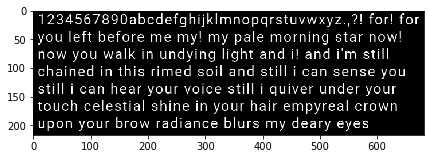

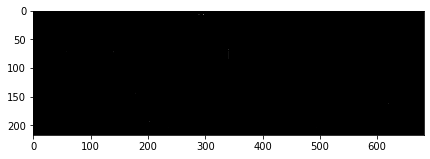

Converted text
 1 22?4bb72g. 8ab6defgb6oku8 85bcq0st8vw, xyzn6rui f5uui f50
 y58 heft bef5u!e 8 e 8 mymim8 y baue 8 508u8g stau! 85wmim
 85w, y58 ,wauk j8 ,88dyl8g 5 gbt a8,d 9, a8d u 8 st8ouo
 6bau8, ed u8 tblsn98 ed s56 a8,d s,stu3,u 6a8 se8se y58
 ts5t3836ubu6ae8hebsetala0hys5b8u,u8! evu5,u86 ye5s8tu!u38cuau6qr8eu8v8ebhy808eadue6hu!y!5w880
 8p58 y58u! b05w 0adla86e bh80s 8 y deca0y eyes

Char Original Converted Percentage
a	17	17	100%
b	4	16	400%
c	9	3	33%
d	10	10	100%
e	23	23	100%
f	5	5	100%
g	4	5	125%
h	8	6	75%
i	26	4	15%
j	1	1	100%
k	2	2	100%
t	11	11	100%
l	18	4	22%
m	9	5	55%
n	22	2	9%
o	20	3	15%
p	4	1	25%
q	2	2	100%
r	21	2	9%
s	14	15	107%
u	14	29	207%
v	3	3	100%
w	6	6	100%
x	1	1	100%
y	15	15	100%
z	1	1	100%
0	1	10	1000%
1	1	1	100%
2	1	3	300%
3	1	4	400%
4	1	1	100%
5	1	20	2000%
6	1	12	1200%
7	1	1	100%
8	1	49	4900%
9	1	2	200%
.	1	1	100%
,	1	12	1200%
?	1	1	100%
!	5	7	140%


In [35]:
ocr = OCRRecognizer("insomnium3.png", "sans-serif", leprous)
ocr.plot_image()
ocr.match_chars(False)
ocr.plot_image()
print("Converted text")
print(ocr.convert_to_text())
ocr.report_detection()

In [ ]:
ocr = OCRRecognizer("ocr_ihsahn.png", "sans-serif", ihsahn)
ocr.plot_image()
ocr.match_chars()
ocr.plot_image()
ocr.report_detection()

## Konwersja obróconego obrazu
W przypadku obróconego obrazu, przed dopasowywaniem wzorców, przywrócono go do poziomej orientacji. Wykorzystano do tego funkcje biblioteki OpenCV, a całość opiera się na znalezieniu prostokąta zawierającego całość tekstu, określeniu jego nachylenia i obróceniu obrazu o ten kąt. Stopień wykrycia znaków nie uległ pogorszeniu w wyniku tej operacji.

In [ ]:
ocr = OCRRecognizer("ocr_leprous_rotated.png", "sans-serif", leprous)
ocr.plot_image()
ocr.rotate_image()
ocr.plot_image()
ocr.match_chars(False)
ocr.plot_image()
print(ocr.convert_to_text())
ocr.report_detection()

## Konwersja obrazu z czcionką szeryfową

W przypadku czcionki szeryfowej konieczna była modyfikacja parametrów - kolejności przetwarzania znaków oraz progów odcięcia. Stopień poprawnego wykrycia znaków uległ nieznacznemu pogorszeniu w stosunku do czcionki bezszeryfowej, aczkolwiek wciąż mieści się w akceptowalnym przedziale.

In [ ]:
ocr = OCRRecognizer("ocr_ihsahn_serif.png", "serif", ihsahn)
ocr.plot_image()
ocr.match_chars(False)
ocr.plot_image()
print(ocr.convert_to_text())
ocr.report_detection()

## Konwersja obrazu na którym występuje szum

Do usuwania szumu wykorzystano transformatę Fouriera. Po zdekomponowaniu obrazu do dziedziny częstotliwości odcięto wyższe jej wartości. W wyniku uzyskano obraz nieco bardziej rozmyty, natomiast zachowano wysoki procent poprawnie wykrywanych znaków.

In [ ]:
ocr = OCRRecognizer("ocr_noise.png", "sans-serif", noise)
ocr.plot_image()
ocr.denoise_image()
ocr.plot_image()
ocr.match_chars(False)
print(ocr.convert_to_text())
ocr.report_detection()

## Wnioski
Zastosowana metoda nie jest najlepszą do realizacji OCR. Każda z czcionek wymagała indywidualnego, drobiazgowego doboru parametrów, ponadto nawet niewielkie zakłócenia powodowały duże błędy przy detekcji. Ponadto gdy na testowych obrazach nie występowały wszystkie wykrywane litery to algorytm nie działał poprawnie, co wynikało z doboru maksimów korelacji.